# V.9

- ResNet50 사용
- 이미지 상단 제목 데이터 추가

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
wandb.login(key='')
run = wandb.init(project='CV_contest_V9', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [6]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms, pipeline):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms
        self.pipeline = pipeline

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.pipeline(img)
        img = self.transforms(img)
    
        return img, target

In [7]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [10]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((500, 500))
])

augmentations = [
    NoiseTexturize(sigma_range=(6, 10),
                  turbulence_range=(5, 10),
                  texture_width_range=(50, 500),
                  texture_height_range=(50, 500)),
    BrightnessTexturize(texturize_range=(0.9, 0.99), deviation=0.2),
    Folding(fold_count=2,
            fold_noise=0.0,
            fold_angle_range = (-180,180),
            gradient_width=(0.01, 0.05),
            gradient_height=(0.01, 0.05),
            backdrop_color = (0,0,0)),
    BadPhotoCopy(
        noise_type=-1,
        noise_side="random",
        noise_iteration=(1, 2),
        noise_size=(1, 3),
        noise_value=(128, 196),
        noise_sparsity=(0.3, 0.6),
        noise_concentration=(0.1, 0.6),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(3, 3), (5, 5), (7, 7)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.33,
    ),    
]

pipeline = AugraphyPipeline(augmentations)

train_dataset = customdataset('/data/ephemeral/home/data/modified_train.csv', '/data/ephemeral/home/data/train', transforms=aug_transforms, pipeline=pipeline)

In [11]:
len(train_dataset)

1570

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


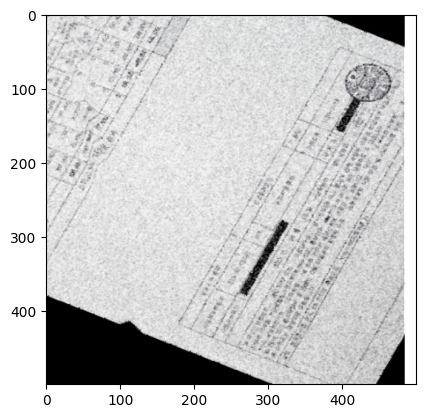

In [20]:
plt.imshow(train_dataset[1][0].permute(1, 2, 0))

# valid dataset

## 민준형 최고 점수 결과 사용

In [21]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
])

pipeline = AugraphyPipeline()

valid_dataset = customdataset('/data/ephemeral/home/preds/minjun_best_score_3.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms, pipeline=pipeline) # valid dataset

In [22]:
len(valid_dataset)

3140

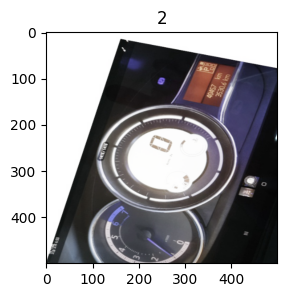

In [23]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [25]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [1]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v9_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 50:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v9_last.pt")
            print('Early Stopping')
            break

    return model

In [27]:
model = timm.create_model(
    'resnet152',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [29]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 500)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 2.7955, Train Accuracy: 0.0720 Valid Loss: 2.9072, Valid Accuracy: 0.0640


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/500], Train Loss: 2.4521, Train Accuracy: 0.1471 Valid Loss: 11.6695, Valid Accuracy: 0.0618


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/500], Train Loss: 2.2053, Train Accuracy: 0.2210 Valid Loss: 2.6725, Valid Accuracy: 0.0930


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/500], Train Loss: 2.0883, Train Accuracy: 0.2522 Valid Loss: 4.4885, Valid Accuracy: 0.0640


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/500], Train Loss: 1.9190, Train Accuracy: 0.3268 Valid Loss: 4.3533, Valid Accuracy: 0.0780


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/500], Train Loss: 1.8879, Train Accuracy: 0.3420 Valid Loss: 5.1747, Valid Accuracy: 0.0653


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/500], Train Loss: 1.7242, Train Accuracy: 0.4013 Valid Loss: 2.5197, Valid Accuracy: 0.1987


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/500], Train Loss: 1.5410, Train Accuracy: 0.4631 Valid Loss: 9.2063, Valid Accuracy: 0.0627


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/500], Train Loss: 1.4800, Train Accuracy: 0.5025 Valid Loss: 4.1157, Valid Accuracy: 0.1131


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 1.3821, Train Accuracy: 0.5146 Valid Loss: 3.3949, Valid Accuracy: 0.2140


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/500], Train Loss: 1.2862, Train Accuracy: 0.5548 Valid Loss: 3.9084, Valid Accuracy: 0.1908


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/500], Train Loss: 1.2277, Train Accuracy: 0.5726 Valid Loss: 2.7881, Valid Accuracy: 0.1013


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/500], Train Loss: 1.2692, Train Accuracy: 0.5707 Valid Loss: 5.3497, Valid Accuracy: 0.2478


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/500], Train Loss: 1.2642, Train Accuracy: 0.5669 Valid Loss: 4.1263, Valid Accuracy: 0.2385


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/500], Train Loss: 1.1234, Train Accuracy: 0.6000 Valid Loss: 10.3349, Valid Accuracy: 0.1398


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/500], Train Loss: 1.2018, Train Accuracy: 0.5834 Valid Loss: 6.5265, Valid Accuracy: 0.0672


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/500], Train Loss: 1.0481, Train Accuracy: 0.6287 Valid Loss: 3.0545, Valid Accuracy: 0.0650


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/500], Train Loss: 1.0756, Train Accuracy: 0.6242 Valid Loss: 4.5259, Valid Accuracy: 0.1127


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/500], Train Loss: 1.0167, Train Accuracy: 0.6554 Valid Loss: 12.1840, Valid Accuracy: 0.0844


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/500], Train Loss: 1.0074, Train Accuracy: 0.6637 Valid Loss: 11.0258, Valid Accuracy: 0.0583


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/500], Train Loss: 0.9793, Train Accuracy: 0.6726 Valid Loss: 2.3005, Valid Accuracy: 0.3446


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/500], Train Loss: 0.9869, Train Accuracy: 0.6516 Valid Loss: 5.2695, Valid Accuracy: 0.2220


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/500], Train Loss: 0.9594, Train Accuracy: 0.6656 Valid Loss: 1.7148, Valid Accuracy: 0.4745


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/500], Train Loss: 0.8741, Train Accuracy: 0.7051 Valid Loss: 6.1579, Valid Accuracy: 0.2280


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/500], Train Loss: 0.8989, Train Accuracy: 0.7000 Valid Loss: 3.9670, Valid Accuracy: 0.2344


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/500], Train Loss: 0.8444, Train Accuracy: 0.7191 Valid Loss: 6.4196, Valid Accuracy: 0.0975


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/500], Train Loss: 0.7908, Train Accuracy: 0.7261 Valid Loss: 4.4937, Valid Accuracy: 0.1618


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/500], Train Loss: 0.7799, Train Accuracy: 0.7261 Valid Loss: 2.5360, Valid Accuracy: 0.2694


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/500], Train Loss: 0.7390, Train Accuracy: 0.7401 Valid Loss: 9.3683, Valid Accuracy: 0.2013


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/500], Train Loss: 0.7493, Train Accuracy: 0.7287 Valid Loss: 3.4007, Valid Accuracy: 0.2736


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/500], Train Loss: 0.7081, Train Accuracy: 0.7516 Valid Loss: 1.6190, Valid Accuracy: 0.5232


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/500], Train Loss: 0.6520, Train Accuracy: 0.7682 Valid Loss: 7.7200, Valid Accuracy: 0.2462


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/500], Train Loss: 0.6411, Train Accuracy: 0.7758 Valid Loss: 2.7546, Valid Accuracy: 0.2857


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/500], Train Loss: 0.6548, Train Accuracy: 0.7682 Valid Loss: 3.5049, Valid Accuracy: 0.2602


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/500], Train Loss: 0.6308, Train Accuracy: 0.7815 Valid Loss: 4.2205, Valid Accuracy: 0.1061


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/500], Train Loss: 0.6369, Train Accuracy: 0.7796 Valid Loss: 12.2640, Valid Accuracy: 0.1162


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/500], Train Loss: 0.6270, Train Accuracy: 0.7803 Valid Loss: 24.6091, Valid Accuracy: 0.0879


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/500], Train Loss: 0.5933, Train Accuracy: 0.7968 Valid Loss: 1.8616, Valid Accuracy: 0.4404


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/500], Train Loss: 0.5980, Train Accuracy: 0.7707 Valid Loss: 3.0488, Valid Accuracy: 0.2720


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/500], Train Loss: 0.5557, Train Accuracy: 0.8108 Valid Loss: 1.3967, Valid Accuracy: 0.6096


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/500], Train Loss: 0.5799, Train Accuracy: 0.7943 Valid Loss: 1.9624, Valid Accuracy: 0.5118


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/500], Train Loss: 0.5850, Train Accuracy: 0.7930 Valid Loss: 3.8708, Valid Accuracy: 0.1373


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/500], Train Loss: 0.5754, Train Accuracy: 0.8032 Valid Loss: 6.2307, Valid Accuracy: 0.1115


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/500], Train Loss: 0.5761, Train Accuracy: 0.7981 Valid Loss: 3.1151, Valid Accuracy: 0.1439


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/500], Train Loss: 0.5744, Train Accuracy: 0.8000 Valid Loss: 8.5595, Valid Accuracy: 0.2303


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/500], Train Loss: 0.5201, Train Accuracy: 0.8134 Valid Loss: 15.3679, Valid Accuracy: 0.0936


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/500], Train Loss: 0.5090, Train Accuracy: 0.8223 Valid Loss: 1.8705, Valid Accuracy: 0.4866


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/500], Train Loss: 0.4969, Train Accuracy: 0.8229 Valid Loss: 2.9728, Valid Accuracy: 0.2825


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/500], Train Loss: 0.5163, Train Accuracy: 0.8229 Valid Loss: 3.4108, Valid Accuracy: 0.3382


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/500], Train Loss: 0.4773, Train Accuracy: 0.8338 Valid Loss: 2.7715, Valid Accuracy: 0.3497


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [51/500], Train Loss: 0.4550, Train Accuracy: 0.8446 Valid Loss: 2.9059, Valid Accuracy: 0.3325


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [52/500], Train Loss: 0.4447, Train Accuracy: 0.8465 Valid Loss: 2.9346, Valid Accuracy: 0.3774


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [53/500], Train Loss: 0.5149, Train Accuracy: 0.8350 Valid Loss: 4.7371, Valid Accuracy: 0.2080


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [54/500], Train Loss: 0.4831, Train Accuracy: 0.8185 Valid Loss: 6.1522, Valid Accuracy: 0.1608


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [55/500], Train Loss: 0.4570, Train Accuracy: 0.8401 Valid Loss: 2.6583, Valid Accuracy: 0.4411


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [56/500], Train Loss: 0.4524, Train Accuracy: 0.8389 Valid Loss: 2.5514, Valid Accuracy: 0.3908


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [57/500], Train Loss: 0.4414, Train Accuracy: 0.8395 Valid Loss: 2.8421, Valid Accuracy: 0.3427


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [58/500], Train Loss: 0.4624, Train Accuracy: 0.8420 Valid Loss: 4.0174, Valid Accuracy: 0.0904


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [59/500], Train Loss: 0.4333, Train Accuracy: 0.8420 Valid Loss: 3.5891, Valid Accuracy: 0.3131


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [60/500], Train Loss: 0.4139, Train Accuracy: 0.8465 Valid Loss: 2.2019, Valid Accuracy: 0.4029


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [61/500], Train Loss: 0.4259, Train Accuracy: 0.8510 Valid Loss: 1.9581, Valid Accuracy: 0.5309


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [62/500], Train Loss: 0.3835, Train Accuracy: 0.8675 Valid Loss: 2.7567, Valid Accuracy: 0.3685


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [63/500], Train Loss: 0.4384, Train Accuracy: 0.8535 Valid Loss: 4.4803, Valid Accuracy: 0.0752


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [64/500], Train Loss: 0.4134, Train Accuracy: 0.8516 Valid Loss: 5.9755, Valid Accuracy: 0.1296


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [65/500], Train Loss: 0.4369, Train Accuracy: 0.8465 Valid Loss: 6.7465, Valid Accuracy: 0.0688


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [66/500], Train Loss: 0.4482, Train Accuracy: 0.8420 Valid Loss: 2.8787, Valid Accuracy: 0.3395


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [67/500], Train Loss: 0.4173, Train Accuracy: 0.8446 Valid Loss: 4.3131, Valid Accuracy: 0.4309


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [68/500], Train Loss: 0.4435, Train Accuracy: 0.8510 Valid Loss: 5.5401, Valid Accuracy: 0.3930


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [69/500], Train Loss: 0.4080, Train Accuracy: 0.8592 Valid Loss: 9.2398, Valid Accuracy: 0.2541


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [70/500], Train Loss: 0.3657, Train Accuracy: 0.8650 Valid Loss: 9.6569, Valid Accuracy: 0.0758


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [71/500], Train Loss: 0.3807, Train Accuracy: 0.8675 Valid Loss: 1.4114, Valid Accuracy: 0.6293


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [72/500], Train Loss: 0.3671, Train Accuracy: 0.8777 Valid Loss: 12.0751, Valid Accuracy: 0.1554


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [73/500], Train Loss: 0.3756, Train Accuracy: 0.8662 Valid Loss: 2.7755, Valid Accuracy: 0.4497


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [74/500], Train Loss: 0.3622, Train Accuracy: 0.8688 Valid Loss: 4.9408, Valid Accuracy: 0.1099


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [75/500], Train Loss: 0.4456, Train Accuracy: 0.8529 Valid Loss: 16.4158, Valid Accuracy: 0.1732


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [76/500], Train Loss: 0.4628, Train Accuracy: 0.8446 Valid Loss: 6.1394, Valid Accuracy: 0.0271


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [77/500], Train Loss: 0.3666, Train Accuracy: 0.8656 Valid Loss: 2.3415, Valid Accuracy: 0.5140


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [78/500], Train Loss: 0.3630, Train Accuracy: 0.8643 Valid Loss: 1.9050, Valid Accuracy: 0.5478


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [79/500], Train Loss: 0.3786, Train Accuracy: 0.8752 Valid Loss: 4.9296, Valid Accuracy: 0.1943


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [80/500], Train Loss: 0.4020, Train Accuracy: 0.8586 Valid Loss: 2.5591, Valid Accuracy: 0.3650


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [81/500], Train Loss: 0.3625, Train Accuracy: 0.8637 Valid Loss: 1.9219, Valid Accuracy: 0.5516


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [82/500], Train Loss: 0.3381, Train Accuracy: 0.8694 Valid Loss: 1.5747, Valid Accuracy: 0.6213


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [83/500], Train Loss: 0.3389, Train Accuracy: 0.8675 Valid Loss: 8.3135, Valid Accuracy: 0.0545


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [84/500], Train Loss: 0.3658, Train Accuracy: 0.8764 Valid Loss: 1.8362, Valid Accuracy: 0.5525


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [85/500], Train Loss: 0.3422, Train Accuracy: 0.8713 Valid Loss: 1.5310, Valid Accuracy: 0.6236


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [86/500], Train Loss: 0.3412, Train Accuracy: 0.8764 Valid Loss: 5.2604, Valid Accuracy: 0.1573


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [87/500], Train Loss: 0.3370, Train Accuracy: 0.8771 Valid Loss: 11.9723, Valid Accuracy: 0.0946


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [88/500], Train Loss: 0.3249, Train Accuracy: 0.8924 Valid Loss: 6.9127, Valid Accuracy: 0.2207


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [89/500], Train Loss: 0.3218, Train Accuracy: 0.8822 Valid Loss: 4.5992, Valid Accuracy: 0.2596


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [90/500], Train Loss: 0.3641, Train Accuracy: 0.8611 Valid Loss: 3.8001, Valid Accuracy: 0.3414
Early Stopping


# Submission

In [5]:
model = timm.create_model(
    'resnet152',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v9_best.pt'))

criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 8

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [9]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/393 [00:00<?, ?it/s]

In [10]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 te

In [11]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [12]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [13]:
sub_df.to_csv('/data/ephemeral/home/preds/v9_best_preds.csv', index=False)

In [14]:
cnt_list = [0 for _ in range(17)]

for i in range(17):
    cnt_list.append(sub_df[sub_df['target']==i].shape[0])

print(cnt_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 75, 379, 329, 264, 55, 100, 104, 222, 180, 272, 297, 219, 26, 31, 171, 204]
